In [1]:
import numpy as np 
import pandas as pd 
import random 
import sys 
import matplotlib.pyplot as plt


In [2]:
class RBFNetwork(object):
    """ RBF Neural Network
    Parameters
    ----------
    X_train: Train Dataset 
    y_train: Labels for Train Dataset 
    X_test: Test Dataset
    y_test: Labels for Test Dataset 
    center: Center for the Network (Should be an array)  
    epochs: Number of Iteration to run for the complete Dataset (Default: 200)
    spread: Default([0.4, 0.8, 1.2]) 
    eta: Default(0.05) 
        Learning rate for the network
    seed: Random seed for the network 
    """

    def __init__(self, X_train, y_train, X_test, y_test, center, epochs=300,\
        spread= [0.2, 0.6, 1.2], eta=0.005, seed=42):
        """ Initialization of the Network """
        self.random = np.random.RandomState(seed)
        self.X_train = X_train 
        self.y_train = y_train 
        self.X_test = X_test 
        self.y_test = y_test 
        self.center = center
        self.epochs = epochs
        self.spread = spread
        self.eta = eta  
        self.weights = np.random.randn(352,1)
        self.bias = np.random.randn(1)
        self.error_buffer = np.zeros((3,self.epochs))
        
    def rbf(self, data, standard_deviation): 
        """ RBF Function for the Hidden layer of the Network 
        Parameters: 
        -----------
        data: The input required for calculating the value 

        Attributes: 
        -----------
        rbf_value: Value after applying rbf function on to 
                   the input data
        """

        rbf_value = np.exp(-1/(2* standard_deviation**2) * (data)**2)
        return rbf_value

    def sigmoid(self, data): 
        """ Activation Function for the Output layer
        Parameters: 
        -----------
        data: Output data from the hidden layer
        Attributes: 
        -----------
        sigmoid_value: Value after applying activation
        function for each data
        """
        sigmoid_value = 1/(1+np.exp(-data))
        return sigmoid_value

    def plot(self): 
        """ Plot function to plot the dataset """
        epoch_list = np.arange(0, 300, 1)
        error_buffer_dataframe=pd.DataFrame(self.error_buffer.T,\
        columns=['Spread=0.2','Spread=0.6','Spread=1.2'])      
        plt.plot(epoch_list, error_buffer_dataframe['Spread=0.2'], 'y-.', label='Spread=0.2')
        plt.plot(epoch_list, error_buffer_dataframe['Spread=0.6'], 'r-', label='Spread=0.6' )
        plt.plot(epoch_list, error_buffer_dataframe['Spread=1.2'], 'b-.', label='Spread=1.2')
        plt.title("Each Spread Plot Error and the Number of Epochs ")
        plt.xlabel("Epochs")
        plt.ylabel("Error")
        plt.legend(loc = 'best')
        plt.show()

    def data_to_center_cal(self):
        """ This is mainly to find the distance from the center 
        and store it in the buffer  
        Attributes: 
        -----------
        distance_buffer: return the distance buffer of the 
        dataset from the center        
        """ 
        for index_i in range(len(self.center)):   
            dist = np.linalg.norm(self.X_train - self.center[index_i,],axis=1)
            self.distance_buffer = np.vstack([self.distance_buffer, dist])

        return self.distance_buffer[1:, ]

    def predict(self):
        """ Prediction function for the dataset 
        Attributes: 
        ------------
        y_pred: Predicted labels for the test dataset 
        """
        self.predicted_distance_buffer = np.zeros((1, len(self.X_test))) 
        for index_i in range(len(self.center)):
            dist = np.linalg.norm(self.X_test - self.center[index_i, ], axis =1)
            self.predicted_distance_buffer = \
            np.vstack([self.predicted_distance_buffer, dist])

        predicted_distance_buffer_sliced = self.predicted_distance_buffer[1:,].T  
        hl_output = self.rbf(predicted_distance_buffer_sliced, self.spread[1])
        forward_op = np.dot(hl_output, self.weights) + self.bias 
        ol_output = self.sigmoid(forward_op)
        y_pred = np.round(ol_output)

        return y_pred 

    def accuracy_score(self, y_pred): 
        """ To Calculate the Accuracy Score
        Parameters: 
        ------------
        y_pred: Predicted labels from the network 
        Attributes: 
        return the Accuracy Score for the dataset 
        """
        y_pred = y_pred.flatten()
        y_test = self.y_test.flatten()
        AccuracyScore = 0 
        for index_i in range(len(self.y_test)): 
            if y_pred[index_i] == y_test[index_i]: 
                AccuracyScore += 1

        return ((AccuracyScore/len(self.y_test))*100) 

    def train(self): 
        """
        Train Function for the RBF Neural Network 
        """
        index_buffer = -1 
        
        # For Each of the Spread 
        for index_spread in self.spread: 
            index_buffer+=1
            self.weights = np.random.randn(self.center.shape[0],1)
            self.bias = np.random.randn(1)

            # For Each of the Epochs 
            for epoch in range(self.epochs): 
                self.distance_buffer = np.zeros((1, self.X_train.shape[0]))
                distance_buffer_sliced = self.data_to_center_cal()
                feature_set = self.rbf(distance_buffer_sliced, index_spread)
                op_hidden = np.dot(feature_set.T, self.weights) + self.bias
                op_activation = self.sigmoid(op_hidden)
                op_error = (op_activation - self.y_train)
                mean_square_error = np.square(op_error).sum()/ self.X_train.shape[0]
                op_Abserror = np.abs(op_error)
                sys.stderr.write("\n Epoch: {0}/{1} | Spread: {2} | Loss: {3:.3f} ".\
                format(epoch + 1, self.epochs, index_spread, mean_square_error))
                sys.stderr.flush() 
                inputs = feature_set.T 
                # Weight Update 
                self.weights = self.weights - self.eta * np.dot(inputs.T, op_error)
                # Bias Update 
                for index_i in op_error: 
                    self.bias = self.bias - self.eta * index_i 
                self.error_buffer[int(index_buffer), epoch] = mean_square_error 


## Dataset Generation from the given Equation 


In [3]:
# Dataset generation 
np.random.seed(42)
X_i = []
X_j = []
X_i_random = []
X_j_random = []
X_i_Positive = []
X_i_negative = []
X_j_positve = []
X_j_negative = []

X_rand=np.zeros((441,3))

for index_i in range(21):
    x_i_value = -2 + (0.2 * index_i) 
    X_i.append(x_i_value)
    X_j.append(x_i_value)

In [4]:
# Choose 441 point randomly to form X_rand 
for index_j in range(441):
    x_i = random.choice(X_i)
    x_j = random.choice(X_j)
    X_i_random.append(x_i)
    X_j_random.append(x_j)
    X_rand[index_j, 0] = x_i 
    X_rand[index_j, 1] = x_j 


In [5]:
# Target Value Generation
target = []
for value in range(len(X_i_random)):
    x_i = X_i_random[value]
    x_j = X_j_random[value]
    target_value = np.square(x_i) + np.square(x_j)
    if target_value <= 1:
        target.append(1)
        X_rand[value, 2] = 1
    elif target_value > 1: 
        target.append(0)
        X_rand[value, 2] = 0
        
    target_value = 0

In [6]:
# Combine the Dataset as per X_i, X_j and Target for further splitting the dataset  
X_value = X_rand[:, :2]
data = pd.DataFrame(X_rand,columns=['X_i','X_j','Target'])
y_value = data[['Target']].values 

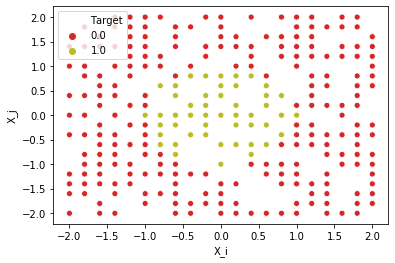

In [7]:
# Plot the Generated Dataset 
import seaborn as sns
sns.scatterplot(x='X_i',y='X_j', hue='Target',data=data, palette=["C3", "C8"])

In [8]:
# Dataset divided into X_train, X_test, y_train, y_test 
X_train = X_value[:308, :]
y_train = y_value[:308]
X_test = X_value[308:, :]
y_test = y_value[308:]


In [9]:
# Initialize the RBFNetwork Class with the dataset
rbf_real = RBFNetwork(X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test, center = X_train)

In [10]:
# Train the RBF Neural Network using the Dataset 
rbf_real.train()


 Epoch: 144/300 | Spread: 0.6 | Loss: 0.007
 Epoch: 145/300 | Spread: 0.6 | Loss: 0.007
 Epoch: 146/300 | Spread: 0.6 | Loss: 0.007
 Epoch: 147/300 | Spread: 0.6 | Loss: 0.007
 Epoch: 148/300 | Spread: 0.6 | Loss: 0.007
 Epoch: 149/300 | Spread: 0.6 | Loss: 0.007
 Epoch: 150/300 | Spread: 0.6 | Loss: 0.007
 Epoch: 151/300 | Spread: 0.6 | Loss: 0.007
 Epoch: 152/300 | Spread: 0.6 | Loss: 0.007
 Epoch: 153/300 | Spread: 0.6 | Loss: 0.007
 Epoch: 154/300 | Spread: 0.6 | Loss: 0.007
 Epoch: 155/300 | Spread: 0.6 | Loss: 0.007
 Epoch: 156/300 | Spread: 0.6 | Loss: 0.007
 Epoch: 157/300 | Spread: 0.6 | Loss: 0.007
 Epoch: 158/300 | Spread: 0.6 | Loss: 0.007
 Epoch: 159/300 | Spread: 0.6 | Loss: 0.007
 Epoch: 160/300 | Spread: 0.6 | Loss: 0.007
 Epoch: 161/300 | Spread: 0.6 | Loss: 0.007
 Epoch: 162/300 | Spread: 0.6 | Loss: 0.007
 Epoch: 163/300 | Spread: 0.6 | Loss: 0.007
 Epoch: 164/300 | Spread: 0.6 | Loss: 0.007
 Epoch: 165/300 | Spread: 0.6 | Loss: 0.007
 Epoch: 166/300 | Spread: 0.6 |

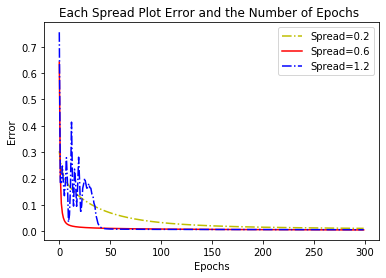

In [11]:
# Plot the Spread with respect to number of Epochs  
rbf_real.plot()

In [12]:
# Predict the labels for the Test dataset 
y_pred = rbf_real.predict()

In [13]:
# Calculate the Accuracy for the RBF Network for all the Training points 
acc_score = rbf_real.accuracy_score(y_pred)
sys.stderr.write("Accuracy Score For 150 Random Centers is: {0:3f}".format(acc_score))
sys.stderr.flush()

Accuracy Score For 150 Random Centers is: 90.977444

### Analysis 

#### The above plot is for the loss of three different spreads '0.2', '0.6' and '1.2' with the Total number of Epochs at 300 in this case when the centers are all the points in the dataset. From the plot it is evident that the spread 1.2 has the highest mean squared error at epoch 1 and this oscillates between 0.051 to 0.45 until Epoch 45. After Epoch 50, as the epoch increases the mean squared error decreases further and at Epoch 300 its value gets very close to zero. For the spread 0.6 as we can see that the graph is smooth with no oscillations and the mean squared error during the initial stage is approximately 0.65 and as the number of epochs increases the mean squared error decreases rapidly, at epoch 50 itself the mean squared error is very close to zero which is not the case with other spreads. In the spread 0.2 the initial mean squared error is lower than the two spreads it is approximately 0.3 and this mean squared error decreases faster than the spread 1.2 but it still remains higher than the spread 0.6. The mean squared error for spread 0.2 remains higher than that of other spread even at higher epochs. So from this we can see that spread 0.6 performs better than other spreads as the its mean squared error decreases faster than the other spreads.

## Q3.2 Use 150 random datapoints for Calculations 

In [14]:
# Choose 150 point randomly to form X_rand_150 
X_rand_150 = np.zeros((150,2))
X_i_random_150 = []
X_j_random_150 = []
for index_j in range(150):
    x_i = random.choice(X_i)
    x_j = random.choice(X_j)
    X_i_random_150.append(x_i)
    X_j_random_150.append(x_j)
    X_rand_150[index_j, 0] = x_i 
    X_rand_150[index_j, 1] = x_j 

In [15]:
# Initialize the Neural Network 
rbf_150_random = RBFNetwork(X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test, center = X_rand_150)

In [16]:
# Train the RBF Neural Network 
rbf_150_random.train()


 Epoch: 144/300 | Spread: 0.6 | Loss: 0.009
 Epoch: 145/300 | Spread: 0.6 | Loss: 0.009
 Epoch: 146/300 | Spread: 0.6 | Loss: 0.009
 Epoch: 147/300 | Spread: 0.6 | Loss: 0.009
 Epoch: 148/300 | Spread: 0.6 | Loss: 0.009
 Epoch: 149/300 | Spread: 0.6 | Loss: 0.009
 Epoch: 150/300 | Spread: 0.6 | Loss: 0.009
 Epoch: 151/300 | Spread: 0.6 | Loss: 0.009
 Epoch: 152/300 | Spread: 0.6 | Loss: 0.009
 Epoch: 153/300 | Spread: 0.6 | Loss: 0.009
 Epoch: 154/300 | Spread: 0.6 | Loss: 0.009
 Epoch: 155/300 | Spread: 0.6 | Loss: 0.009
 Epoch: 156/300 | Spread: 0.6 | Loss: 0.009
 Epoch: 157/300 | Spread: 0.6 | Loss: 0.009
 Epoch: 158/300 | Spread: 0.6 | Loss: 0.009
 Epoch: 159/300 | Spread: 0.6 | Loss: 0.009
 Epoch: 160/300 | Spread: 0.6 | Loss: 0.009
 Epoch: 161/300 | Spread: 0.6 | Loss: 0.008
 Epoch: 162/300 | Spread: 0.6 | Loss: 0.008
 Epoch: 163/300 | Spread: 0.6 | Loss: 0.008
 Epoch: 164/300 | Spread: 0.6 | Loss: 0.008
 Epoch: 165/300 | Spread: 0.6 | Loss: 0.008
 Epoch: 166/300 | Spread: 0.6 |

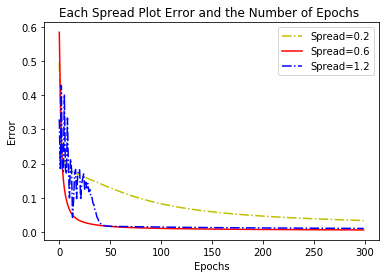

In [17]:
# Plot the Spread with respect to the number of Epochs for 150 Random Dataset  
rbf_150_random.plot()

In [18]:
# Predict the labels for the Test dataset 
y_pred_150_random = rbf_150_random.predict()

In [19]:
# Calculate the Accuracy for the RBF Network for 150 Random points 
acc_score = rbf_150_random.accuracy_score(y_pred_150_random)
sys.stderr.write("Accuracy Score For 150 Random Centers is: {0:3f}".format(acc_score))
sys.stderr.flush()

Accuracy Score For 150 Random Centers is: 93.233083

### Analysis 

#### The above plot is for the loss of three different spreads '0.2', '0.6' and '1.2' with the total number of Epochs of 300 when the centers are 150 randomly choosen point from the dataset. From the plot it is evident that the spread 0.6 has the highest mean squared error of approximately 0.6 at epoch 1. For the spread 1.2 when epochs is less than 60 its mean squared error oscillates between 0.03 to approximately 0.4. After Epoch 60, as the epoch increases the mean squared error decreases further and at Epoch 300 its value gets very close to zero. For the spread 0.6 as we can see that the graph is smooth with no oscillations and the mean squared error during the initial stage is approximately 0.49 and as the number of epochs increases the mean squared error decreases rapidly, at epoch 60 itself the mean squared error is very close to zero which is not the case with other spreads. In the spread 0.2 the initial mean squared error is higher than that of spread 1.2 at 0.45 and this mean squared error decreases very slowly as compared to the other spreads and even at epoch 300 the mean squared error doesn't approach zero. So from this analysis, we can say that the spread 0.6 performs better than other spreads as the its mean squared error decreases faster than the other spreads.

## Q3.2 Use KMeans Clustering for Center selection 


In [20]:
# Import KMeans from sklearn 
from sklearn.cluster import KMeans
kmeans=KMeans(n_clusters=150)
kmeans.fit(X_train)
centers_kmeans = kmeans.cluster_centers_

In [21]:
# Initialize the RBF Network with 150 centers generated using KMeans 
rbf_150_kmeans = RBFNetwork(X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test, center = centers_kmeans)

In [22]:
# Train the Network for 150 KMeans generated Centers 
rbf_150_kmeans.train()


 Epoch: 144/300 | Spread: 0.6 | Loss: 0.010
 Epoch: 145/300 | Spread: 0.6 | Loss: 0.010
 Epoch: 146/300 | Spread: 0.6 | Loss: 0.010
 Epoch: 147/300 | Spread: 0.6 | Loss: 0.010
 Epoch: 148/300 | Spread: 0.6 | Loss: 0.010
 Epoch: 149/300 | Spread: 0.6 | Loss: 0.010
 Epoch: 150/300 | Spread: 0.6 | Loss: 0.010
 Epoch: 151/300 | Spread: 0.6 | Loss: 0.010
 Epoch: 152/300 | Spread: 0.6 | Loss: 0.010
 Epoch: 153/300 | Spread: 0.6 | Loss: 0.010
 Epoch: 154/300 | Spread: 0.6 | Loss: 0.009
 Epoch: 155/300 | Spread: 0.6 | Loss: 0.009
 Epoch: 156/300 | Spread: 0.6 | Loss: 0.009
 Epoch: 157/300 | Spread: 0.6 | Loss: 0.009
 Epoch: 158/300 | Spread: 0.6 | Loss: 0.009
 Epoch: 159/300 | Spread: 0.6 | Loss: 0.009
 Epoch: 160/300 | Spread: 0.6 | Loss: 0.009
 Epoch: 161/300 | Spread: 0.6 | Loss: 0.009
 Epoch: 162/300 | Spread: 0.6 | Loss: 0.009
 Epoch: 163/300 | Spread: 0.6 | Loss: 0.009
 Epoch: 164/300 | Spread: 0.6 | Loss: 0.009
 Epoch: 165/300 | Spread: 0.6 | Loss: 0.009
 Epoch: 166/300 | Spread: 0.6 |

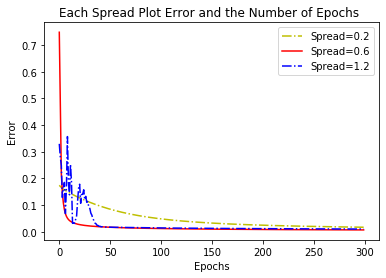

In [23]:
# Plot the Spread with respect to Epochs for 150 KMeans generated Centers 
rbf_150_kmeans.plot()

In [24]:
# Predict the labels for the Test dataset 
y_pred_150_kmeans = rbf_150_kmeans.predict()

In [25]:
# Calculate the Accuracy Score for the Test Dataset 
acc_score_kmeans = rbf_150_kmeans.accuracy_score(y_pred_150_kmeans)
sys.stderr.write("Accuracy Score For 150 Random Centers is: {0:3f}".format(acc_score_kmeans))
sys.stderr.flush()

Accuracy Score For 150 Random Centers is: 94.736842

### Analysis 

#### The above plot is for the loss of three different spreads '0.2', '0.6' and '1.2' with the total number of Epochs of 300 when the centers are choosen using KMeans algorithm. From the plot it is evident that the spread 0.6 has the highest mean squared error of 0.75 at epoch 1. For the spread 1.2 the mean squared error is lower from the above two plots and it is at approximately 0.18 the oscillation is lower in magnitude and for oscillates for lower number of epochs. After epochs 45 the mean squared error decreases and it follows approximately the same path as that of the spread 0.6 and at epoch 300 it approximately reaches to zero. For the spread 0.2 the mean squared error starts with a lower value at approximately 0.11. However, this value doesn't decrease as expected the value decreases very slowly and even at epoch 300 the value is higher than that of the other two spreads. So from this analysis, we can say that the spread 0.6 performs better than other spreads as the its mean squared error decreases faster than the other spreads.

## Analysis 

#### For analysis on the Accuracy for each of the method for 300 epochs it is clear that the Accuracy obtained by selecting all the datapoints as centers is approximately 90.98% whereas the accuracy obtained for 150 randomly selected centers is around 93.23%. The accuracy obtained when we select the centers using KMeans algorithm is around 94.74% in addition to high the  accuracy it also gives high accuracy in lower epochs. All the methods tend to give decent accuracy as the spread is 0.6 in all cases. The spead is choosen after carefully analysing the graph for spreads which has lowest error in minimum number of Epochs.